## Time series with time structured parameters and summary statistics

Idea: construct a model $p(x|\theta)$ with $\theta = (\theta_1,...\theta_n)$ and summary statistics $s(x) = (s_1(x),...s_m(x))$ s.t.


for all $i$ there exists a $j$, $j\leq m$, and $l$, $j\leq l$ such that
 
$p(s_{1:i}|\theta_{1:n} ) = p(s_{1:i}|\theta_{1:j}) $.

and 

$p(s_{1:i+1}|\theta_{1:n} ) = p(s_{1:i+1}|\theta_{1:l}) $.

### Examples:
1. Piecewise linear function:
 - $\theta_{1,2}$ : a and b of linear function f(x) = ax + b
 - $\theta_{3,4}$ : time of changing point cp, and a2 of second slope

 2. Sinusoidal waves with linearly increasing/decreasing amplitudes, and changing points at which this linear function changes.
 


In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt


import sys
sys.path.append('../code/')

import torch

In [2]:
# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import SNPE_C
from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

## Piecewise_linear() and simulation wrappers for SBI

I defined a seperate function for each sequential step such that we can vary different numbers of parameters

In [3]:
start = get_time()



def piecewise_linear(a1,b, a2,a3, cp1, cp2, add_noise=None):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    

    return y


def piecewise_linear_first_batch(thetas):
    """
    I defined a seperate function for each sequential step such that we can vary different numbers of parameters
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2 = np.float32(-2)
    a3 = np.float32(3)
    cp1 = np.float32(3)
    cp2 = np.float32(6)
    
    add_noise=0.1
    
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 

    
    return y


def piecewise_linear_second_batch(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2 = thetas[2]
    a3 = thetas[3]
    cp1 = np.float32(3)
    cp2 = np.float32(6)
    
    add_noise=0.1
    
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = torch.arange(0,10,0.01)
    y = torch.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 

    
    return y


def piecewise_linear_third_batch(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2 = thetas[2]
    a3 = thetas[3]
    cp1 = thetas[4]
    cp2 = thetas[5]
    
    add_noise=0.1
    
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = torch.arange(0,10,0.01)
    y = torch.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 

    
    return y

### Define prior and summary stats dependent on prior

In [4]:
"""
Priors
"""

b = scp.random.uniform(0,10)
a1 = scp.random.uniform(-10,0)
a2 = scp.random.uniform(0,10)
a3 = scp.random.uniform(-10,0)
cp1 = scp.random.uniform(2,4)
cp2 = scp.random.uniform(5,8)


x = piecewise_linear(a1,b, a2,a3, cp1, cp2)



**Summary statistics**

I defined a few more summary statistics such that we have 13 in total.

In [5]:
"""
Summary stats
"""

def extract_sumstats(y,max_time=10):
    """
    Extract some sumstats for piecewise linear fct with specified prior 
    !the information in the sumstats is highly dependent on the prior!
    Args:
        x ([array]): time axis of time series
        y ([array]): 1d time series
        max_time (float, optional): maximal time to calculate sumstats on. Defaults to 10.

    Returns:
       s [array]: summary stats of time series, with np.nan for non-calculated sumstats
    """
    
    # artificial masking of y 
    
    x = torch.arange(0,10,0.01, dtype=torch.float64)

    
    batch_list = []
    # first batch of sumstats for times <4
    
    for batch in y:
        
        
        batch[x>max_time] = np.nan
    
        s = np.zeros(13) * np.nan
        
        s[0] = np.float32(batch[0])    #offset
        s[1] = np.nanmin(batch[x<4])   # local min
        
        #print(type(s[0]), type(s[1]))
        s[2] = x[np.nanargmin(batch[x<4])]   #value of min
        
        s[3] = np.nanmax(batch[x<4])   # local max
        
  
        s[4] = x[np.nanargmax(batch[x<4])]   #value of max

        # second batch of sumstats for times > 4
        if max_time >= 4 :
            s[5] = np.nanmax(batch[(x>=4)&(x<8)])
            s[6] = x[np.nanargmax(batch[(x>=4)&(x<8)])] + 4
            s[9] = np.nanmin(batch[(x>=4)&(x<8)])
            s[10] = x[np.nanargmin(batch[(x>=4)&(x<8)])] +4

        # third batch of sumstats for times > 5
        if max_time >= 5:
            s[7] = np.nanmin(batch[x>=5])
            s[8] = x[np.nanargmin(batch[x>=5])] + 5
            
            s[11] = np.nanmax(batch[x>=5])
            s[12] = x[np.nanargmax(batch[x>=5])] + 5
            
        s = np.float32(s)
    
            
        batch_list.append(torch.from_numpy(s))

    return torch.stack(batch_list)

    

## cosine waves

WORK IN PROGRESS

same, but more ellaborated summary stats are needed

In [6]:
def cosine_waves(a1,b,a2,cp,f_1=1, f_2=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset (starting amplitude)
        a2 (float): second slope
        cp (float): changing point
        f_1 (float): first freq
        f_2 (float): second freq

    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp])
    factor1[factor1<0] = 0
    y[x<cp] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp])
     
    factor2= y[np.sum(x<cp)-1] + a2* (x[x>=cp] - cp) 
    factor2[factor2<0] = 0

    y[x>=cp] = (factor2) * np.cos(2*np.pi * f_2 * x[x>=cp]) 

    if return_factors:
        return x,y, factor1, factor2
    else:
        return x,y

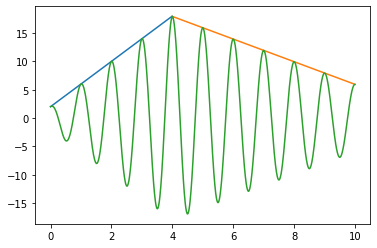

In [7]:
x,y,f1,f2=cosine_waves(4,2,-2,4, return_factors=True  )

plt.plot(x[:len(f1)],f1)
plt.plot(x[-len(f2):],f2)
plt.plot(x,y)

In [8]:
def cosine_waves_2(a1,b,a2,a3, cp1, cp2, f_1=1, f_2=1,f_3=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y
    
    
def cosine_waves_2_first(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2=-3
    a3=3
    cp1=2
    cp2=6
    f_1=1
    f_2=1
    f_3=1
    
    return_factors=False
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y

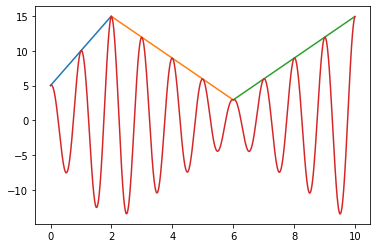

In [9]:
x,y,f1,f2,f3=cosine_waves_2(5,5,
                            -3,3,
                            2,6, return_factors=True)

plt.plot(x[:len(f1)],f1)
plt.plot(x[len(f1):-len(f3)],f2)
plt.plot(x[-len(f3):],f3)

plt.plot(x,y)

## Sequential Time Series SBI


We have the follwoing parameters: a1,b,a2,a3, cp1, cp2

Let's assume this ground truth: true_params = $[5, 5, -3, 2, 1, 5]$

and the following uniform priors: 

prior_min = $[3, 3, -5, 0, -1, 3]  $

prior_max = $[7, 7, -1, 4, 3, 7]$


We start with inferring the first 2 parameters (a1, b), therefore call the function $piecewise_linear_first_batch()$
that only varies these 2 parameters within the prior range.

In [10]:
#parameter a1,b,a2,a3, cp1, cp2



prior_min = [3, 3, -5, 0, -1, 3]  

prior_max = [7, 7, -1, 4, 3, 7]

num_simulations=1000

## First round

In [11]:
### first round:

prior1 = utils.torchutils.BoxUniform(low=prior_min[0:2], high = prior_max[0:2])

print(prior_min[0:2])
print(prior1)

inf = SNPE_C(prior1, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_first_batch, prior1)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

[3, 3]
BoxUniform(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1)


/tmp/ipykernel_106638/1110274676.py:62: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)
/tmp/ipykernel_106638/1110274676.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
x = extract_sumstats(x_without)

In [13]:
inf = inf.append_simulations(theta, x)
density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)

Neural network successfully converged after 70 epochs.


In [14]:
true_params = [5, 5, -3, 2, 1, 5]
obs_real = piecewise_linear_first_batch(true_params)


print(obs_real.shape)

obs_real_stats = extract_sumstats([obs_real])


print(obs_real_stats.shape)

torch.Size([1000])
torch.Size([1, 13])


In [38]:
num_samples = 100

samples = posterior.sample((num_samples,), x=obs_real_stats)

proposal1 = posterior.set_default_x(obs_real_stats)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
samples_0 = []

for i in samples:
    samples_0.append(i[0])
print(samples_0)

[tensor(5.0203), tensor(4.8080), tensor(5.1849), tensor(5.0411), tensor(4.9631), tensor(4.8617), tensor(4.8273), tensor(4.9450), tensor(4.9585), tensor(4.8313), tensor(4.9909), tensor(5.1343), tensor(4.8503), tensor(4.8932), tensor(4.7172), tensor(4.8837), tensor(4.9881), tensor(4.9732), tensor(4.9567), tensor(5.0156), tensor(4.9330), tensor(4.9056), tensor(4.8854), tensor(4.8567), tensor(5.0115), tensor(5.0041), tensor(5.0947), tensor(4.8875), tensor(5.0655), tensor(4.9619), tensor(4.8410), tensor(4.9649), tensor(4.9586), tensor(5.0440), tensor(4.9687), tensor(5.0407), tensor(4.7813), tensor(5.0006), tensor(5.0007), tensor(4.9361), tensor(4.8112), tensor(4.8282), tensor(4.8213), tensor(4.8368), tensor(5.0482), tensor(4.8995), tensor(5.0890), tensor(4.9061), tensor(4.9791), tensor(5.0214), tensor(4.6917), tensor(5.0261), tensor(4.7415), tensor(4.9663), tensor(4.8991), tensor(4.9978), tensor(5.0312), tensor(5.0566), tensor(5.0075), tensor(5.1282), tensor(4.9423), tensor(5.1063), tensor(

5.3228884
4.6916857


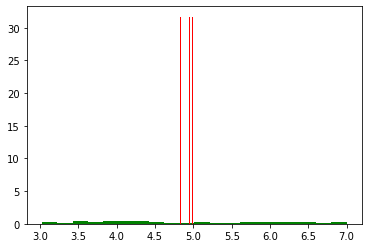

In [45]:
### comparing samples range from posterior and prior:
data = np.random.uniform(prior_min[0],prior_max[0],100) # You are generating 1000 points between 0 and 1.

plt.hist(data, 20, facecolor='green', density=True) 
plt.hist(samples_0, 20, facecolor='red', density=True)


print(np.max(samples_0))
print(np.min(samples_0))

In [46]:
print(prior_max[0]-prior_min[0])
print(np.max(samples_0)-np.min(samples_0))

4
0.6312027


In [49]:
100/(4/0.631)

15.775

So, the parameter range takes now only 15.775% of the uniform prior space!!

## Second round

In [16]:
#### second round



prior2 = utils.torchutils.BoxUniform(low=prior_min[2:4], high = prior_max[2:4])


prior_combined =Combined(proposal1, prior2, number_params_1=2)



inf = SNPE_C(prior_combined, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_second_batch, prior_combined)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 5.0126,  5.0575, -2.3998,  0.8756]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.9024,  5.0469, -1.1445,  1.3631]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 4.9820,  4.9085, -1.4621,  2.1125]])
tensor([-0.6583])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 5.1477,  5.0214, -4.9940,  0.9785]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 5.2364,  4.8370, -3.5518,  3.4677]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 5.0105,  5.1693, -1.1266,  1.8102]])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta pos size torch.Size([2, 2])
theta prior size torch.Size([2, 2])
2
theta tensor([[ 4.9651,  5.0332, -3.7792,  2.1462],
        [ 5.0462,  4.9286, -2.9553,  1.3217]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 5.0005,  5.0173, -2.1802,  3.0492]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 4.9455,  5.0734, -1.1133,  1.6518]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 5.0871,  5.0945, -3.5000,  1.3844]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta pos size torch.Size([1000, 2])
theta prior size torch.Size([1000, 2])
2
theta tensor([[ 5.1258,  5.1093, -1.2917,  0.6688],
        [ 4.9744,  5.0552, -1.5635,  2.5297],
        [ 5.0063,  4.8105, -4.6917,  3.9051],
        ...,
        [ 5.1394,  5.2674, -2.6444,  2.4128],
        [ 4.9222,  4.9570, -4.1783,  1.2277],
        [ 4.9971,  4.9515, -2.7282,  2.9952]])


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior2 = inf.build_posterior(density_estimator)

Neural network successfully converged after 77 epochs.


In [18]:
obs_real = piecewise_linear_second_batch(true_params)


obs_real_stats = extract_sumstats([obs_real])


#print(proposal2.log_prob(theta))

samples = posterior2.sample((num_samples,), x=obs_real_stats)

proposal2 = posterior2.set_default_x(obs_real_stats)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

## Third and last round

In [19]:
#### third round



prior3 = utils.torchutils.BoxUniform(low=prior_min[4:6], high = prior_max[4:6])


prior_combined2 = Combined(proposal2, prior3, number_params_1=4)



inf = SNPE_C(prior_combined2, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_third_batch, prior_combined2)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 4])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 4.9975,  4.8761, -2.9821,  2.3228, -0.5806,  4.1597]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta tensor([[ 5.1213,  4.9459, -3.0947,  2.1714, -0.0477,  6.1107]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 4])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 5.0473,  4.9026, -2.9637,  2.1632,  2.6340,  6.0714]])
tensor([2.3222])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta tensor([[ 5.0566,  5.0961, -3.1238,  2.1032,  2.9293,  4.4246]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.9523,  4.9117, -3.0541,  2.1746,  2.8905,  3.3490]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta tensor([[ 5.0347,  5.0080, -2.8710,  2.0857,  1.2052,  5.3831]])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta pos size torch.Size([2, 4])
theta prior size torch.Size([2, 2])
2
theta tensor([[ 5.0764,  4.9630, -3.1876,  2.2022, -0.1708,  3.2514],
        [ 5.1014,  4.8733, -2.9762,  2.1594, -0.5634,  6.5067]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.9683,  4.9725, -3.1117,  2.2957,  1.2150,  3.8787]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 4])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 5.0423,  4.9597, -2.8841,  2.2601,  0.5152,  5.3757]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 4])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 4.9391,  4.9559, -3.1012,  2.1920, -0.0327,  3.2578]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta pos size torch.Size([1000, 4])
theta prior size torch.Size([1000, 2])
2
theta tensor([[ 4.9559,  4.9849, -2.7784,  2.1252,  2.9978,  3.1216],
        [ 4.9422,  4.8960, -3.0291,  2.4008,  2.9285,  6.6791],
        [ 4.8938,  4.8519, -3.1568,  2.1360,  0.6118,  3.4015],
        ...,
        [ 5.0743,  4.9470, -2.9838,  2.1857,  2.0731,  5.2958],
        [ 4.8168,  4.8459, -3.0437,  2.1420,  1.7128,  3.2168],
        [ 5.0587,  4.9760, -2.9471,  2.2186,  0.7821,  3.1718]])


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior3 = inf.build_posterior(density_estimator)

Neural network successfully converged after 65 epochs.


In [21]:
obs_real = piecewise_linear_third_batch(true_params)


obs_real_stats = extract_sumstats([obs_real])


samples = posterior3.sample((num_samples,), x=obs_real_stats)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [23]:
#end = get_time()


print('start:', start, '\nend:', end)

start: 12-05-2021_16:50:18 
end: 12-05-2021_16:52:17


In [24]:
from joblib import Parallel, delayed

num_workers = 4
x_lin = torch.arange(0,10,0.01, dtype= torch.float32)
s_x = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_third_batch)(sample) for sample in samples)

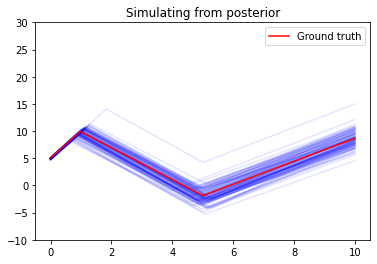

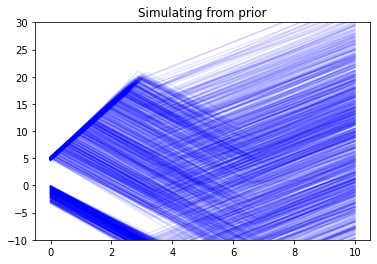

In [25]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from posterior")
for s in s_x:
    im = plt.plot(x_lin, s, alpha=0.1, color='blue')
    plt.ylim(-10,30)
plt.plot(x_lin, obs_real, label='Ground truth', color='red')
plt.legend()
    
    
    
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from prior")
for x_w in x_without:
    plt.plot(x_lin, x_w, alpha=0.1, color='blue')

    plt.ylim(-10,30)


    
    
true_params = [5, 5, -3, 2, 1, 5]
obs_real = piecewise_linear_third_batch(true_params)

In [ ]:
limits = [list(tup) for tup in zip(prior_min, prior_max)]

true_params = torch.tensor([[5, 5, -3, 2, 1, 5]])

parameter_names = ['a1', 'b', 'a2', 'a3', 'cp1', 'cp2' ]

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=limits,
    figsize=(5, 5),
    points=true_params[0:2],
    points_offdiag={"markersize": 6},
    points_colors="r",
    #tick_labels=parameter_names
    labels=parameter_names,
)

In [ ]:
import matplotlib.gridspec as gridspec

x = x

s_real = obs_real_stats[0]



print(x.shape)


print(len(s_x))

fig = plt.figure(figsize=(10,40), tight_layout=True)

gs = gridspec.GridSpec(nrows=x.size(dim=1), ncols=1)


sum_stats_names = torch.arange(1, 14, 1)

print(sum_stats_names)



#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(len(sum_stats_names)-1):

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(len(s_x)-1):
        globals()['sum_stats%s' % i].append(s_x[j][i])
        globals()['x%s' % i].append(x[j][i])



    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=False, facecolor='g', alpha=0.75, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=False, facecolor='b', alpha=0.75, histtype='barstacked', label='simulated')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(s_real[i], color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')





plt.savefig('Summary_stats_post_prior')